### Make OpenEO connection

In [1]:
import openeo
from datetime import datetime  



#token SENTINEL
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


Load in Cube without METEO


In [2]:
#Get desired data
from preprocessing import worldcereal_preprocessed_inputs

EXTENT = dict(zip(["west", "south", "east", "north"], [664000.0, 5611120.0, 665000.0, 5612120.0]))
EXTENT['crs'] = "EPSG:32631"

STARTDATE = '2020-11-01'
ENDDATE = '2021-10-31'

#TODO aggregator for including METEO?

input_cube = worldcereal_preprocessed_inputs(
     connection = connection,
     bbox = EXTENT,
     start = STARTDATE,
     end = ENDDATE,
     METEO_collection=None,
     S2_collection= "SENTINEL2_L2A",
     S1_collection= "SENTINEL1_GRD",
     DEM_collection= "COPERNICUS_30"
)


Save the input cube

In [3]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_input_cube_worldCereal.nc'

input_cube.execute_batch(outputfile = outputfile_name,
                        description='world cereal data collection')

0:00:00 Job 'j-2405225aa91d4f9c986e314482d61a1b': send 'start'


KeyboardInterrupt: 

Run the presto UDF and fetch presto features

In [6]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_presto.nc'

udf = openeo.UDF.from_file("udf_presto.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

presto_list = ["presto_" + str(i) for i in range(1, 129)]
prediction = prediction.rename_labels(dimension="bands",target= presto_list)

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )

0:00:00 Job 'j-240522d4b46c4b85a05d7bac60dbd894': send 'start'
0:00:20 Job 'j-240522d4b46c4b85a05d7bac60dbd894': created (progress 0%)
0:00:25 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:00:34 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:00:42 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:00:52 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:01:05 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:01:21 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:01:40 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:02:05 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:02:36 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:03:13 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:04:00 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (progress N/A)
0:04:59 Job 'j-240522d4b46c4b85a05d7bac60dbd894': running (pro

<BatchJob job_id='j-240522d4b46c4b85a05d7bac60dbd894'>

In [8]:
import xarray as xr
import matplotlib.pyplot as plt

output = xr.open_dataset(outputfile_name)
output['presto_1'].values

array([[[ 1.28030717,  1.24561238,  0.89612383, ..., -0.88404161,
         -0.86419362, -0.94284689],
        [ 1.18315971,  1.24996054,  1.00327194, ..., -0.86914986,
         -0.81153351, -0.78880918],
        [ 1.22972143,  1.34015703,  0.4644534 , ..., -0.88735497,
         -0.86509544, -0.75152397],
        ...,
        [-0.04115722, -0.09354208,  0.06488457, ...,  0.52544767,
          0.68004614,  0.2031192 ],
        [ 0.16457513,  0.18039979,  0.25627238, ...,  0.43219674,
          0.49971986,  0.24406503],
        [ 0.20367333,  0.1553583 ,  0.22572494, ..., -0.35009685,
         -0.44863623, -0.45004168]]])

Calculate the presto features and run the classifier on top

In [3]:

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_worldcereal.nc'

udf = openeo.UDF.from_file("udf_worldcereal_inference.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

prediction = prediction.rename_labels(dimension="bands",target= ["output_catboost"])

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )


0:00:00 Job 'j-2405229dc1614b34a394f847fafe77c2': send 'start'
0:00:25 Job 'j-2405229dc1614b34a394f847fafe77c2': created (progress 0%)
0:00:31 Job 'j-2405229dc1614b34a394f847fafe77c2': created (progress 0%)
0:00:38 Job 'j-2405229dc1614b34a394f847fafe77c2': created (progress 0%)
0:00:46 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:00:58 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:01:11 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:01:27 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:01:48 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:02:13 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:02:43 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:03:21 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:04:08 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progress N/A)
0:05:08 Job 'j-2405229dc1614b34a394f847fafe77c2': running (progr

JobFailedException: Batch job 'j-2405229dc1614b34a394f847fafe77c2' didn't finish successfully. Status: error (after 0:11:15).

Fetch the output and visualise

(116, 144)

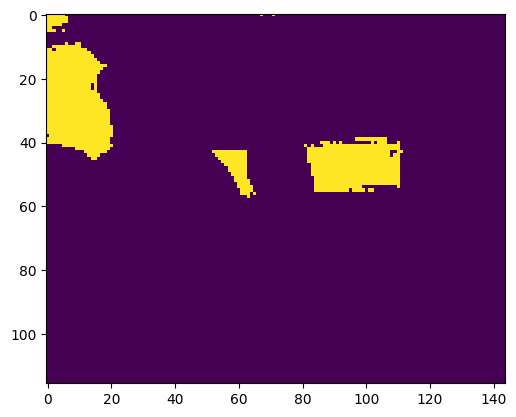

In [10]:
import xarray as xr
import matplotlib.pyplot as plt

output = xr.open_dataset('2024_05_17_14_56_51_output_worldcereal.nc')
output = output['output_catboost'].to_numpy().squeeze()
plt.imshow(output)

output.shape


In [15]:
presto_ft = xr.open_dataset('2024_05_17_14_00_16_output_presto.nc')

print(presto_ft['presto_1'])


<xarray.DataArray 'presto_1' (t: 1, y: 116, x: 144)> Size: 134kB
[16704 values with dtype=float64]
Coordinates:
  * t        (t) datetime64[ns] 8B 1970-01-01
  * x        (x) float64 1kB 6.528e+05 6.528e+05 ... 6.542e+05 6.542e+05
  * y        (y) float64 928B 5.681e+06 5.681e+06 ... 5.68e+06 5.68e+06
Attributes:
    long_name:     presto_1
    units:         
    grid_mapping:  crs


### Check reference

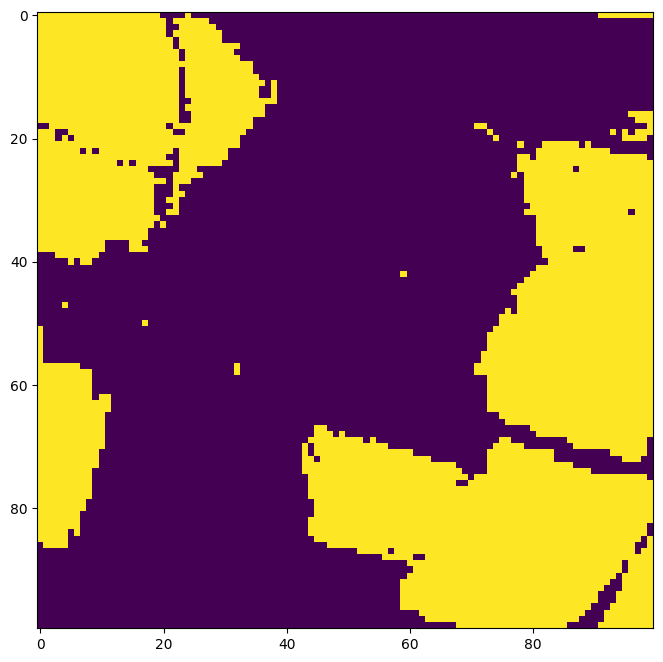